<a href="https://colab.research.google.com/github/albivaltzew/chips_defects/blob/main/chips_defects_anomalib_padim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Train a Model via API

This notebook demonstrates how to train, test and infer the FastFlow model via Anomalib API. Compared to the CLI entrypoints such as \`tools/\<train, test, inference>.py, the API offers more flexibility such as modifying the existing model or designing custom approaches.

# Installing Anomalib

The easiest way to install anomalib is to use pip. You can install it from the command line using the following command:


In [2]:
!git clone https://github.com/openvinotoolkit/anomalib.git
%cd anomalib
%pip install .

Cloning into 'anomalib'...
remote: Enumerating objects: 33488, done.
remote: Counting objects: 100% (3964/3964), done.
remote: Compressing objects: 100% (2329/2329), done.
remote: Total 33488 (delta 2300), reused 2682 (delta 1539), pack-reused 29524
Receiving objects: 100% (33488/33488), 1.51 GiB | 34.41 MiB/s, done.
Resolving deltas: 100% (18898/18898), done.
/content/anomalib
Processing /content/anomalib
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.3 MB/s eta 0:00:00
     ━

In [3]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 51.3 MB/s eta 0:00:00


## Setting up the Dataset Directory

This cell is to ensure we change the directory to have access to the datasets.


In [4]:
from pathlib import Path
Path.cwd()

PosixPath('/content/anomalib')

In [5]:
import os
os.makedirs(Path.cwd() / "datasets" , exist_ok=True)

In [6]:
# importing shutil module
import shutil

# Full path of
# the archive file
filename = "/content/drive/MyDrive/defected_chips/anomaly_chip_defect_dataset.zip"

# Target directory
extract_dir = "/content/anomalib/datasets"

# Format of archive file
archive_format = "zip"

# Unpack the archive file
shutil.unpack_archive(filename, extract_dir, archive_format)
print("Archive file unpacked successfully.")

Archive file unpacked successfully.


In [7]:
dataset_root = Path.cwd() / "datasets" / "anomaly_chip_defect_dataset"
dataset_root

PosixPath('/content/anomalib/datasets/anomaly_chip_defect_dataset')

## Imports


In [8]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00


In [9]:
from functools import partial, update_wrapper
from types import MethodType
from typing import Any

from matplotlib import pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.optim import Optimizer
from torch.optim.adam import Adam
from torch.utils.data import DataLoader

from anomalib.data import InferenceDataset, TaskType
from anomalib.data.mvtec import MVTec
from anomalib.models.fastflow.lightning_model import Fastflow
from anomalib.post_processing import (
    NormalizationMethod,
    ThresholdMethod,
    superimpose_anomaly_map,
)
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import (
    ImageVisualizerCallback,
    MetricsConfigurationCallback,
    MetricVisualizerCallback,
    PostProcessingConfigurationCallback,
)

In [10]:
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer
from anomalib.models import get_model

from anomalib.utils.callbacks import LoadModelCallback, get_callbacks

In [11]:
import numpy as np
from PIL import Image
from torchvision.transforms import ToPILImage

from anomalib.data import TaskType
from anomalib.data.folder import Folder, FolderDataset
from anomalib.data.utils import InputNormalizationMethod, get_transforms

## Data Module

To train the model end-to-end, we do need to have a dataset. In our [previous notebooks](https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/100_datamodules), we demonstrate how to initialize benchmark- and custom datasets. In this tutorial, we will use MVTec AD DataModule. We assume that `datasets` directory is created in the `anomalib` root directory and `MVTec` dataset is located in `datasets` directory.

Before creating the dataset, let's define the task type that we will be working on. In this notebook, we will be working on a segmentation task. Therefore the `task` variable would be:


In [12]:
folder_datamodule = Folder(
    root=dataset_root,
    normal_dir="good",
    abnormal_dir="defected",
    task=TaskType.SEGMENTATION,
    mask_dir=dataset_root / "mask_255",
    image_size=640,
    normalization=InputNormalizationMethod.NONE,  # don't apply normalization, as we want to visualize the images
    num_workers=2,
    train_batch_size=8,
    eval_batch_size=8,

)
folder_datamodule.setup()

In [13]:
# Train images
i, data = next(enumerate(folder_datamodule.train_dataloader()))
print(data.keys(), data["image"].shape)

dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask']) torch.Size([8, 3, 640, 640])


In [14]:
# Test images
i, data = next(enumerate(folder_datamodule.test_dataloader()))
print(data.keys(), data["image"].shape, data["mask"].shape)

dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask']) torch.Size([8, 3, 640, 640]) torch.Size([8, 640, 640])


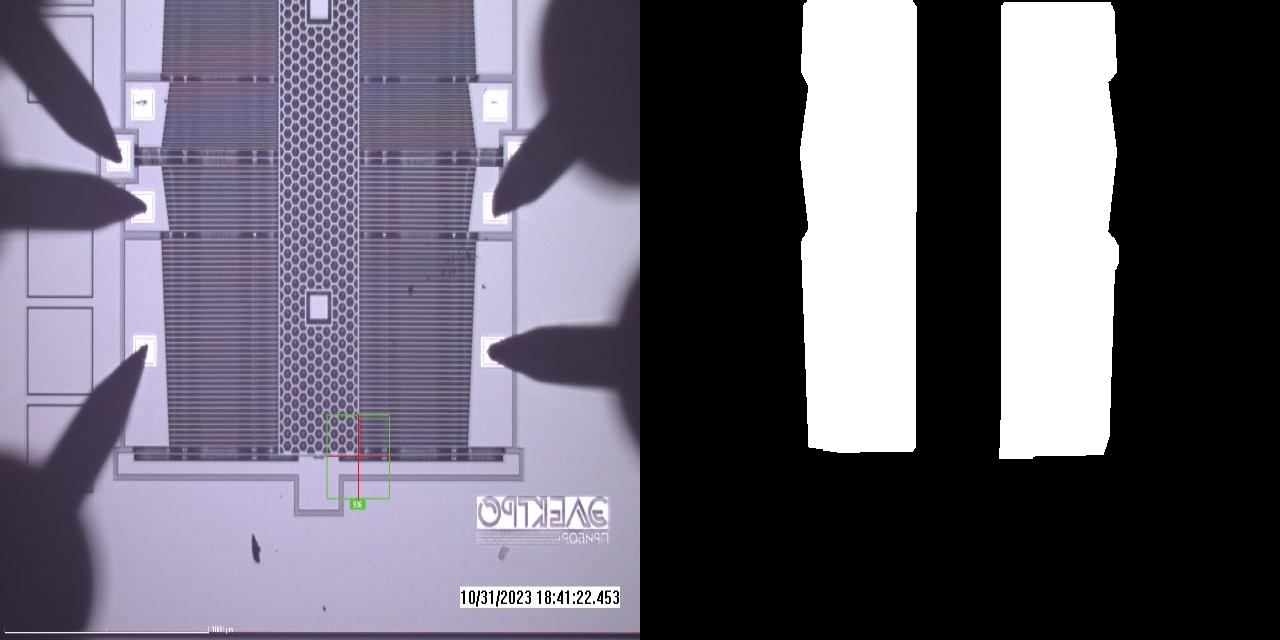

In [15]:
img = ToPILImage()(data["image"][0].clone())
msk = ToPILImage()(data["mask"][0]).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))

In [16]:
image_size = (256, 256)
transform = get_transforms(image_size=256, normalization=InputNormalizationMethod.NONE)

In [17]:
# Folder Segmentation Train Set
folder_dataset_segmentation_train = FolderDataset(
    normal_dir=dataset_root / "good",
    abnormal_dir=dataset_root / "defected",
    split="train",
    transform=transform,
    mask_dir=dataset_root / "mask_255",
    task=TaskType.SEGMENTATION,
)


folder_dataset_segmentation_train.setup()  # like the datamodule, the dataset needs to be set up before use
folder_dataset_segmentation_train.samples.head()

,image_path,label,label_index,mask_path,split
0,/content/anomalib/datasets/anomaly_chip_defect...,DirType.NORMAL,0,,Split.TRAIN
1,/content/anomalib/datasets/anomaly_chip_defect...,DirType.NORMAL,0,,Split.TRAIN
2,/content/anomalib/datasets/anomaly_chip_defect...,DirType.NORMAL,0,,Split.TRAIN
3,/content/anomalib/datasets/anomaly_chip_defect...,DirType.NORMAL,0,,Split.TRAIN
4,/content/anomalib/datasets/anomaly_chip_defect...,DirType.NORMAL,0,,Split.TRAIN


In [18]:
# Folder Segmentation Test Set
folder_dataset_segmentation_test = FolderDataset(
    normal_dir=dataset_root / "good",
    abnormal_dir=dataset_root / "defected",
    split="test",
    transform=transform,
    mask_dir=dataset_root / "mask_255",
    task=TaskType.SEGMENTATION,
)
folder_dataset_segmentation_test.setup()  # like the datamodule, the dataset needs to be set up before use
folder_dataset_segmentation_test.samples.head(10)

,image_path,label,label_index,mask_path,split
0,/content/anomalib/datasets/anomaly_chip_defect...,DirType.ABNORMAL,1,/content/anomalib/datasets/anomaly_chip_defect...,Split.TEST
1,/content/anomalib/datasets/anomaly_chip_defect...,DirType.ABNORMAL,1,/content/anomalib/datasets/anomaly_chip_defect...,Split.TEST
2,/content/anomalib/datasets/anomaly_chip_defect...,DirType.ABNORMAL,1,/content/anomalib/datasets/anomaly_chip_defect...,Split.TEST
3,/content/anomalib/datasets/anomaly_chip_defect...,DirType.ABNORMAL,1,/content/anomalib/datasets/anomaly_chip_defect...,Split.TEST
4,/content/anomalib/datasets/anomaly_chip_defect...,DirType.ABNORMAL,1,/content/anomalib/datasets/anomaly_chip_defect...,Split.TEST
5,/content/anomalib/datasets/anomaly_chip_defect...,DirType.ABNORMAL,1,/content/anomalib/datasets/anomaly_chip_defect...,Split.TEST
6,/content/anomalib/datasets/anomaly_chip_defect...,DirType.ABNORMAL,1,/content/anomalib/datasets/anomaly_chip_defect...,Split.TEST
7,/content/anomalib/datasets/anomaly_chip_defect...,DirType.ABNORMAL,1,/content/anomalib/datasets/anomaly_chip_defect...,Split.TEST
8,/content/anomalib/datasets/anomaly_chip_defect...,DirType.ABNORMAL,1,/content/anomalib/datasets/anomaly_chip_defect...,Split.TEST
9,/content/anomalib/datasets/anomaly_chip_defect...,DirType.ABNORMAL,1,/content/anomalib/datasets/anomaly_chip_defect...,Split.TEST


In [19]:
data = folder_dataset_segmentation_test[3]
print(data.keys(), data["image"].shape, data["mask"].shape)

dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask']) torch.Size([3, 256, 256]) torch.Size([256, 256])


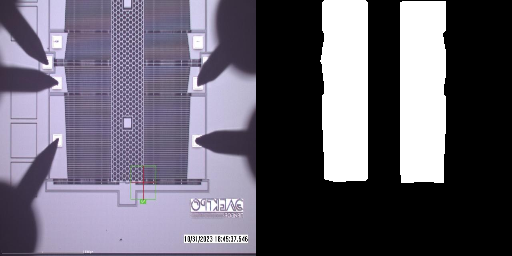

In [20]:
img = ToPILImage()(data["image"].clone())
msk = ToPILImage()(data["mask"]).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))

In [21]:
# task = TaskType.SEGMENTATION

In [22]:
# datamodule = MVTec(
#     root=dataset_root,
#     category="bottle",
#     image_size=256,
#     train_batch_size=32,
#     eval_batch_size=32,
#     num_workers=8,
#     task=task,
# )
# datamodule.setup()
# i, data = next(enumerate(datamodule.test_dataloader()))
# print(f'Image Shape: {data["image"].shape} Mask Shape: {data["mask"].shape}')

# Configuration

In [30]:
MODEL = "padim"  # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
CONFIG_PATH = "/content/drive/MyDrive/defected_chips/config.yaml"
with open(file=CONFIG_PATH, mode="r", encoding="utf-8") as file:
    print(file.read())

dataset:
  name: anomaly_chip_defect_dataset
  format: folder
  path: /content/anomalib/datasets/anomaly_chip_defect_dataset
  normal_dir: good # name of the folder containing normal images.
  abnormal_dir: defected # name of the folder containing abnormal images.
  normal_test_dir: null # name of the folder containing normal test images.
  task: segmentation # classification or segmentation
  mask: /content/anomalib/datasets/anomaly_chip_defect_dataset/mask_255 #optional
  extensions: null
  split_ratio: 0.2 # ratio of the normal images that will be used to create a test split
  image_size: 224
  train_batch_size: 4
  test_batch_size: 4
  num_workers: 2
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  test_split_mode: from_dir # options: [from_dir, synthetic]
  val_split_mode: same_as_test # options: [same_as_test, from_test, sythetic]
  val_split_ratio: 0.5 # fraction of train/test images held out for validation (usage depends o

In [31]:
config = get_configurable_parameters(config_path=CONFIG_PATH)

/usr/local/lib/python3.10/dist-packages/anomalib/config/config.py:280: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


# Folder Dataset

In [32]:
datamodule = get_datamodule(config)
datamodule.prepare_data()  # Downloads the dataset if it's not in the specified `root` directory
datamodule.setup()  # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask'])


In [33]:
print(data["image"].shape, data["mask"].shape)

torch.Size([4, 3, 224, 224]) torch.Size([4, 224, 224])


/usr/local/lib/python3.10/dist-packages/anomalib/pre_processing/transforms/custom.py:25: UserWarning: Denormalize is no longer used and will be deprecated in v0.4.0
  warnings.warn("Denormalize is no longer used and will be deprecated in v0.4.0")


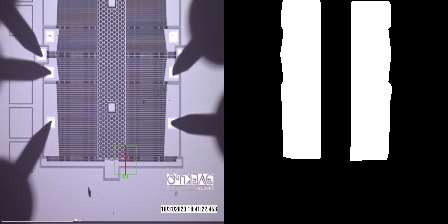

In [34]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    img = ToPILImage()(Denormalize()(sample["image"][index].clone()))
    msk = ToPILImage()(sample["mask"][index]).convert("RGB")

    return Image.fromarray(np.hstack((np.array(img), np.array(msk))))


# Visualize an image with a mask
show_image_and_mask(data, index=0)

# Prepare Model and Callbacks

In [35]:
# Set the export-mode to OpenVINO to create the OpenVINO IR model.
# config.optimization.export_mode = "openvino"

# Get the model and callbacks
model = get_model(config)
callbacks = get_callbacks(config)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [36]:
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training e

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


# Validation

In [37]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)
test_results = trainer.test(model=model, datamodule=datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.8051877617835999     │
│       image_F1Score       │    0.9229208827018738     │
│        pixel_AUROC        │    0.9370315074920654     │
│       pixel_F1Score       │    0.7345753908157349     │
└───────────────────────────┴───────────────────────────┘


# Load a Test Image

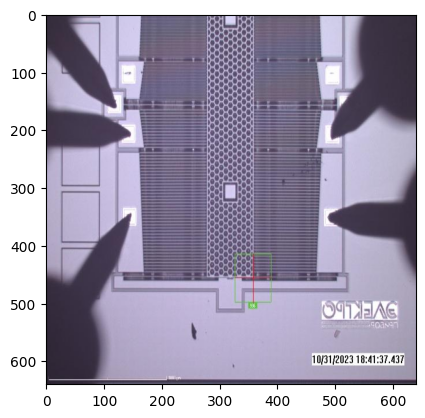

In [38]:
# image_path = root_directory / "datasets/MVTec/bottle/test/broken_large/000.png"
image = read_image(path="/content/anomalib/datasets/anomaly_chip_defect_dataset/defected/bot00003_jpeg.rf.508a7881eb51e74f2ef07ea05210494a.jpg")
plt.imshow(image)

## Load the OpenVINO Model

In [ ]:
# output_path = Path(config["project"]["path"])
# print(output_path)

In [ ]:
# openvino_model_path = output_path / "weights" / "openvino" / "model.bin"
# metadata = output_path / "weights" / "openvino" / "metadata.json"
# print(openvino_model_path.exists(), metadata.exists())

In [ ]:
# inferencer = OpenVINOInferencer(
#     path=openvino_model_path,  # Path to the OpenVINO IR model.
#     metadata=metadata,  # Path to the metadata file.
#     device="CPU",  # We would like to run it on an Intel CPU.
# )

## Perform Inference

In [ ]:
# print(image.shape)

In [ ]:
# predictions = inferencer.predict(image=image)

## Visualizing Inference Results

In [ ]:
# print(predictions.pred_score, predictions.pred_label)

In [ ]:
# # Visualize the original image
# plt.imshow(predictions.image)

In [ ]:
# # Visualize the raw anomaly maps predicted by the model.
# plt.imshow(predictions.anomaly_map)

In [ ]:
# # Visualize the heatmaps, on which raw anomaly map is overlayed on the original image.
# plt.imshow(predictions.heat_map)

In [ ]:
# # Visualize the segmentation mask.
# plt.imshow(predictions.pred_mask)

In [ ]:
# # Visualize the segmentation mask with the original image.
# plt.imshow(predictions.segmentations)

## Callbacks

To train the model properly, we will to add some other "non-essential" logic such as saving the weights, early-stopping, normalizing the anomaly scores and visualizing the input/output images. To achieve these we use `Callbacks`. Anomalib has its own callbacks and also supports PyTorch Lightning's native callbacks. So, let's create the list of callbacks we want to execute during the training.


In [ ]:
# callbacks = [
#     MetricsConfigurationCallback(
#         task=task,
#         image_metrics=["AUROC"],
#         pixel_metrics=["AUROC"],
#     ),
#     ModelCheckpoint(
#         mode="max",
#         monitor="pixel_AUROC",
#     ),
#     EarlyStopping(
#         monitor="pixel_AUROC",
#         mode="max",
#         patience=3,
#     ),
#     PostProcessingConfigurationCallback(
#         normalization_method=NormalizationMethod.MIN_MAX,
#         threshold_method=ThresholdMethod.ADAPTIVE,
#     ),
#     ImageVisualizerCallback(mode="full", task=task, image_save_path="./results/images"),
#     MetricVisualizerCallback(mode="full", task=task, image_save_path="./results/images"),
# ]

## Training

Now that we set up the datamodule, model, optimizer and the callbacks, we could now train the model.

The final component to train the model is `pytorch_lightning` `Trainer` object, which handles train/test/predict pipeline. Let's create the trainer object to train the model.


In [ ]:
# trainer = Trainer(
#     callbacks=callbacks,
#     accelerator="auto",  # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
#     devices=1,
#     max_epochs=100,
#     logger=False,
# )

`Trainer` object has number of options that suit all specific needs. For more details, refer to [Lightning Documentation](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html) to see how it could be tweaked to your needs.

Let's train the model now.


In [ ]:
# trainer.fit(datamodule=datamodule, model=model)

The training has finished after 12 epochs. This is because, we set the `EarlyStopping` criteria with a patience of 3, which terminated the training after `pixel_AUROC` stopped improving. If we increased the `patience`, the training would continue further.

## Testing

Now that we trained the model, we could test the model to check the overall performance on the test set. We will also be writing the output of the test images to a file since we set `VisualizerCallback` in `callbacks`.


In [ ]:
# trainer.test(datamodule=datamodule, model=model)

## Inference

Since we have a trained model, we could infer the model on an individual image or folder of images. Anomalib has an `InferenceDataset` to let you create an inference dataset. So let's try it.


In [39]:
inference_dataset = InferenceDataset(path="/content/anomalib/datasets/anomaly_chip_defect_dataset/defected/bot00003_jpeg.rf.508a7881eb51e74f2ef07ea05210494a.jpg", image_size=(224, 224))
inference_dataloader = DataLoader(dataset=inference_dataset)

We could utilize `Trainer`'s `predict` method to infer, and get the outputs to visualize


In [40]:
predictions = trainer.predict(model=model, dataloaders=inference_dataloader)[0]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 211it [00:00, ?it/s]

`predictions` contain image, anomaly maps, predicted scores, labels and masks. These are all stored in a dictionary. We could check this by printing the `prediction` keys.


In [41]:
print(predictions.keys())

dict_keys(['image', 'image_path', 'anomaly_maps', 'pred_scores', 'pred_labels', 'pred_masks', 'pred_boxes', 'box_scores', 'box_labels'])


In [42]:
print(
    f'Image Shape: {predictions["image"].shape},\n'
    f'Anomaly Map Shape: {predictions["anomaly_maps"].shape}, \n'
    f'Predicted Mask Shape: {predictions["pred_masks"].shape}'
)

Image Shape: torch.Size([1, 3, 224, 224]),
Anomaly Map Shape: torch.Size([1, 1, 224, 224]), 
Predicted Mask Shape: torch.Size([1, 1, 224, 224])


## Visualization


To properly visualize the predictions, we will need to perform some post-processing operations.

Let's post-process each output one by one. We could start with the image. Each `image` is a tensor and within (0, 1) range. To visualize it, we need to denormalize it to (0, 255) scale. Anomalib already has a class for this. Let's use it.


In [43]:
image = predictions["image"][0]
image = Denormalize()(image)
print(f"Image Shape: {image.shape}\n Min Pixel: {image.min()} \n Max Pixel: {image.max()}")

Image Shape: (224, 224, 3)
 Min Pixel: 0 
 Max Pixel: 255


We could now see that `image` is of a numpy array and within the range of \[0, 255\]. It's ready to be visualized now.


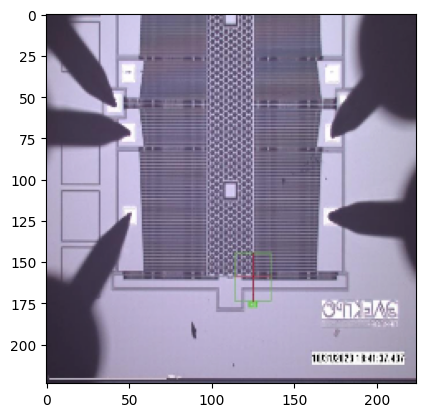

In [44]:
plt.imshow(image)

The second output of the predictions is the anomaly map. As can be seen above, it's also a torch tensor and of size `torch.Size([1, 1, 256, 256])`. We therefore need to convert it to numpy and squeeze the dimensions to make it `256x256` output to visualize.


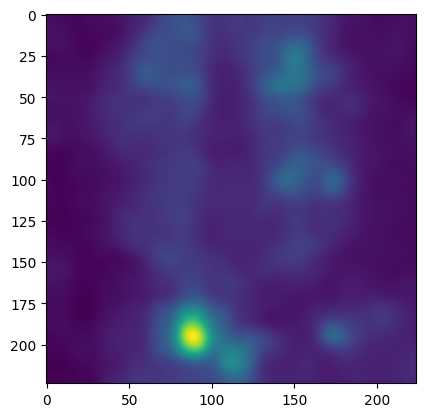

In [45]:
anomaly_map = predictions["anomaly_maps"][0]
anomaly_map = anomaly_map.cpu().numpy().squeeze()
plt.imshow(anomaly_map)

We could superimpose (overlay) the anomaly map on top of the original image to get a heat map. Anomalib has a built-in function to achieve this. Let's try it.


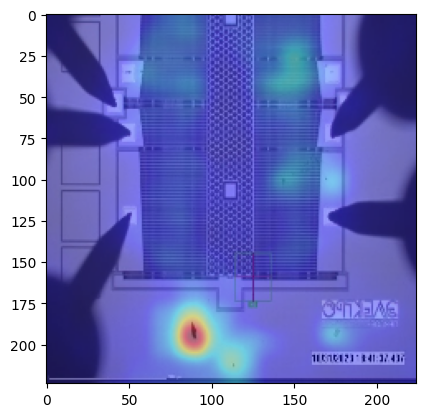

In [46]:
heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
plt.imshow(heat_map)

`predictions` also contains prediction scores and labels.


In [47]:
pred_score = predictions["pred_scores"][0]
pred_labels = predictions["pred_labels"][0]
print(pred_score, pred_labels)

tensor(0.9675) tensor(True)


The last part of the predictions is the mask that is predicted by the model. This is a boolean mask containing True/False for the abnormal/normal pixels, respectively.


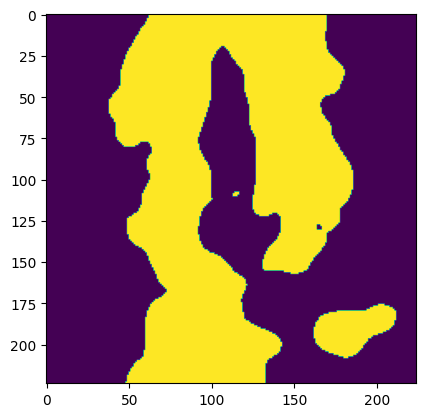

In [48]:
pred_masks = predictions["pred_masks"][0].squeeze().cpu().numpy()
plt.imshow(pred_masks)

That wraps it! In this notebook, we show how we could train, test and finally infer a FastFlow model using Anomalib API.
